In [83]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from seirsplus.models import *
import networkx
import matplotlib.pyplot as plt
import numpy as np
import copy

In [164]:
def plot_models(model, cmodel, cpmodel=None, cpcontrol=None, title="", tmax=500):
    if cpmodel is None:
        cpmodel = []
    cpmodel.append((tmax, ""))
    if cpcontrol is None:
        cpcontrol = []
    cpcontrol.append((tmax, ""))

    model.tseries = np.append(model.tseries, 500)
    model.numS = np.append(model.numS, model.numS[-1])
    model.numI = np.append(model.numI, model.numI[-1])
    model.numE = np.append(model.numE, model.numE[-1])
    model.numR = np.append(model.numR, model.numR[-1])
    model.numD_E = np.append(model.numD_E, model.numD_E[-1])
    model.numD_I = np.append(model.numD_I, model.numD_I[-1])

    cmodel.tseries = np.append(cmodel.tseries, 500)
    cmodel.numS = np.append(cmodel.numS, cmodel.numS[-1])
    cmodel.numI = np.append(cmodel.numI, cmodel.numI[-1])
    cmodel.numE = np.append(cmodel.numE, cmodel.numE[-1])
    cmodel.numR = np.append(cmodel.numR, cmodel.numR[-1])
    cmodel.numD_E = np.append(cmodel.numD_E, cmodel.numD_E[-1])
    cmodel.numD_I = np.append(cmodel.numD_I, cmodel.numD_I[-1])

    y_max = np.max((np.max(cmodel.numI), np.max(cmodel.numE), np.max(cmodel.numD_E), np.max(cmodel.numD_I), np.max(model.numI), np.max(model.numE), np.max(model.numD_E), np.max(model.numD_I)))
    fig = plt.figure(figsize=(13,6))
    fig.suptitle(title)
    ax=plt.subplot(221)
    plt.plot(model.tseries, model.numS, label="Susceptible")
    plt.plot(model.tseries, model.numI, label="Infectious")
    plt.plot(model.tseries, model.numE, label="Exposed")
    plt.plot(model.tseries, model.numR, label="Recovered")
    plt.plot(model.tseries, model.numD_E, label="Detected (exposed)")
    plt.plot(model.tseries, model.numD_I, label="Detected (infectious)")
    checkpoints = cpmodel
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
        plt.text(np.mean((checkpoints[i][0], checkpoints[i+1][0])), 5000, checkpoints[i][1], fontsize=12, rotation=90, va="center", ha="center", color="grey", zorder=-1)
    plt.ylabel("Number of individuals")
    plt.title(f"Testing from day {test_start} ({int(model.numF[-1])} dead, i.e. {model.numF[-1] / model.numNodes * 100}%)")
    plt.xticks([])
    
    ax=plt.subplot(223)
    plt.plot(model.tseries, model.numS, label="Susceptible")
    plt.plot(model.tseries, model.numI, label="Infectious")
    plt.plot(model.tseries, model.numE, label="Exposed")
    plt.plot(model.tseries, model.numR, label="Recovered")
    plt.plot(model.tseries, model.numD_E, label="Detected (exposed)")
    plt.plot(model.tseries, model.numD_I, label="Detected (infectious)")
    checkpoints = cpmodel
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
    plt.ylabel("Number of individuals\n(zoomed in)")
    plt.xlabel("Days")
    plt.ylim(0, y_max)

    ax=plt.subplot(222)
    plt.plot(cmodel.tseries, cmodel.numS, label="Susceptible")
    plt.plot(cmodel.tseries, cmodel.numI, label="Infectious")
    plt.plot(cmodel.tseries, cmodel.numE, label="Exposed")
    plt.plot(cmodel.tseries, cmodel.numR, label="Recovered")
    plt.plot(cmodel.tseries, cmodel.numD_E, label="Detected (exposed)")
    plt.plot(cmodel.tseries, cmodel.numD_I, label="Detected (infectious)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    checkpoints = cpcontrol
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
        plt.text(np.mean((checkpoints[i][0], checkpoints[i+1][0])), 5000, checkpoints[i][1], fontsize=12, rotation=90, va="center", ha="center", color="grey", zorder=-1)
    plt.ylabel("Number of individuals")
    plt.title(f"No testing ({int(cmodel.numF[-1])} dead, i.e. {cmodel.numF[-1] / cmodel.numNodes * 100}%)")
    plt.xticks([])
    
    ax=plt.subplot(224)
    plt.plot(cmodel.tseries, cmodel.numS, label="Susceptible")
    plt.plot(cmodel.tseries, cmodel.numI, label="Infectious")
    plt.plot(cmodel.tseries, cmodel.numE, label="Exposed")
    plt.plot(cmodel.tseries, cmodel.numR, label="Recovered")
    plt.plot(cmodel.tseries, cmodel.numD_E, label="Detected (exposed)")
    plt.plot(cmodel.tseries, cmodel.numD_I, label="Detected (infectious)")
    checkpoints = cpmodel
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
    plt.ylabel("Number of individuals\n(zoomed in)")
    plt.xlabel("Days")
    plt.ylim(0, y_max)

t = 0.01
t = 10.04
[Checkpoint: Updating parameters]
t = 20.00
t = 30.00
t = 40.00
t = 50.03
t = 60.03
t = 70.04
t = 80.02
t = 90.04
t = 100.06
t = 110.27
t = 120.41
t = 130.61
t = 140.87
t = 0.06
t = 10.00
t = 20.00
t = 30.01
t = 40.00
t = 50.01
t = 60.00
t = 70.01
t = 80.00
t = 90.01
t = 100.00
t = 110.01
t = 120.01
t = 130.00
t = 140.01
t = 150.01
t = 160.02
t = 170.03
t = 180.00
t = 190.32
t = 200.07
t = 210.01
t = 220.01
t = 230.80
t = 240.11
t = 250.05


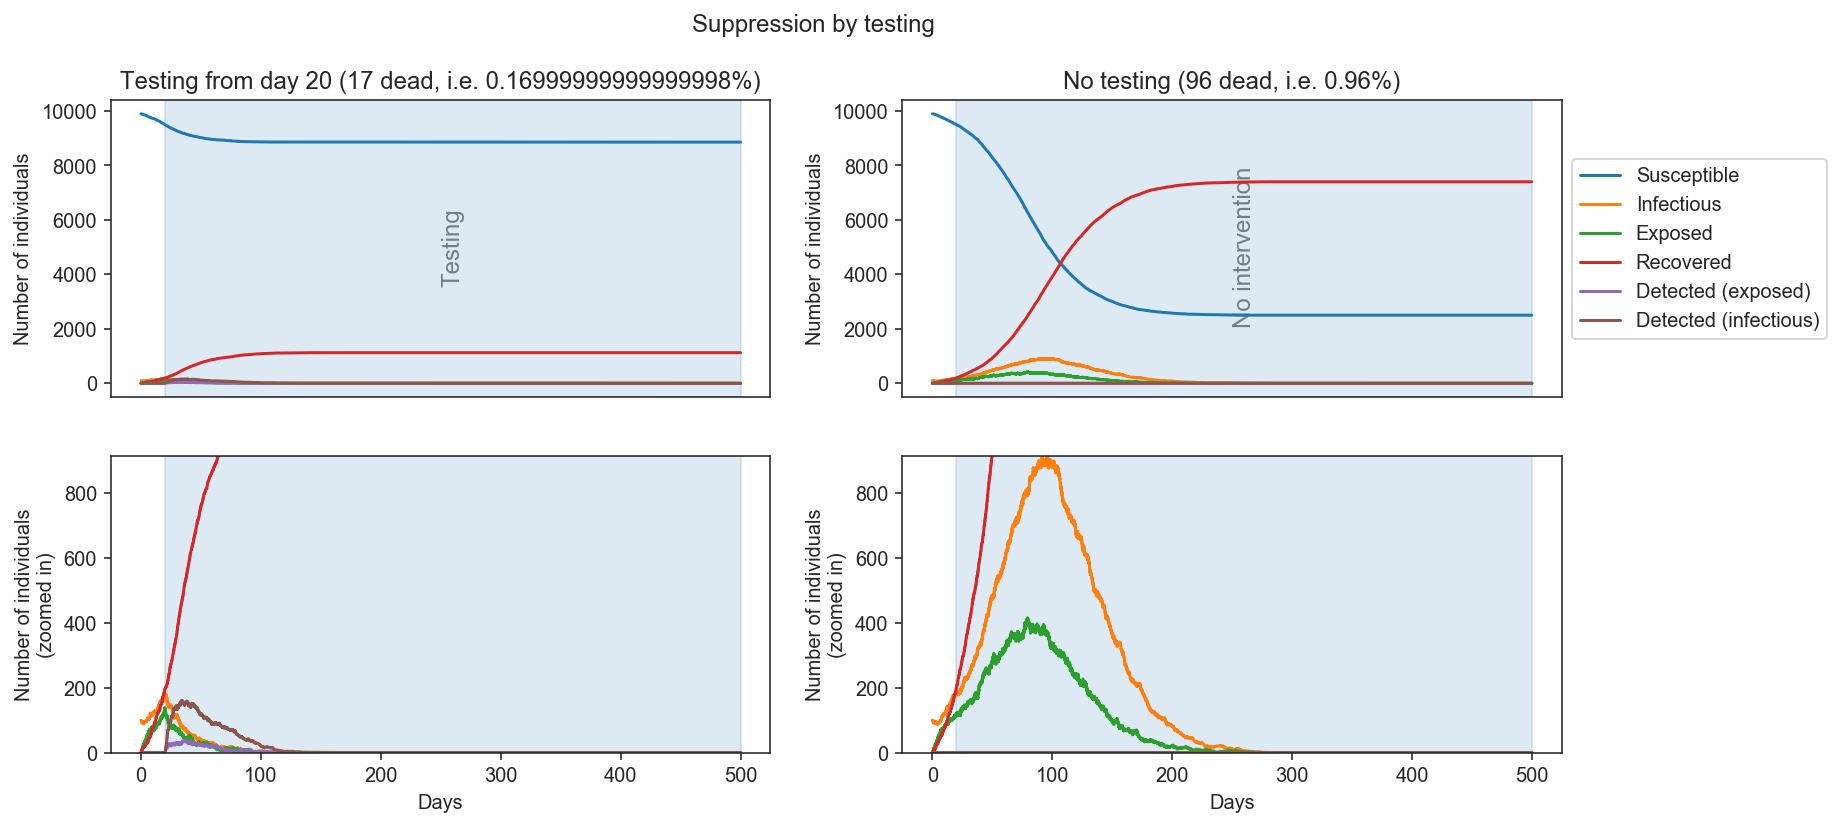

In [171]:
numNodes = 10000           # Size of the population
n_days = 500               # Number of days to simulate
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)


model_params = dict(
    G=G_normal,             # Social graph under normal conditions
    beta=0.155,             # Rate of transmission (transmissions per S-I contact per day)
    sigma=1/5.2,            # Rate of progression (inverse of incubation period)
    gamma=1/12.39,          # Rate of recovery (inverse of infectiopus period)
    mu_I=0.001,             # Death rate of infected individuals
    p=0.5,                  # Locality of contacts (p=0, only local; p=1, only global)
    Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
    beta_D=0.155,           # Rate of transmission for detected cases
    sigma_D=1/5.2,          # Rate of progression for detected cases
    gamma_D=1/12.39,        # Rate of recovery for detected cases
    mu_D=0.001,             # Death rate of detected individuals 
    theta_E=0,              # Rate of testing for exposed individuals
    theta_I=0,              # Rate of testing for infectious individuals
    phi_E=0,                # Rate of contact tracing testing for exposed individuals
    phi_I=0,                # Rate of contact tracing testing for infectious individuals
    psi_E=0.8,              # probability that an exposed individual is correctly identified when tested
    psi_I=0.8,              # probability that an infected individual is correctly identified when tested
    q=0.02,                 # Probability of global interactions for quarantined individuals
    initI=100               # Initial number of infected individuals
)

test_start = 20 # On what day do we start testing?
test_fraction = 1/7 # probability that a person is tested any given day

model = SEIRSNetworkModel(**model_params)
checkpoints = {'t': [test_start], 'theta_E': [test_fraction], 'theta_I': [test_fraction]}
model.run(T=n_days, checkpoints=checkpoints, verbose=False)

# Control model, identical to the above, except we don't use the testing checkpoint
cmodel = SEIRSNetworkModel(**model_params)
cmodel.run(T=n_days, verbose=False)
plot_models(model, cmodel, [(test_start, "Testing")], [(test_start, "No intervention")], "Suppression by testing")

t = 0.01
t = 10.04
[Checkpoint: Updating parameters]
t = 20.04
t = 30.01
t = 40.00
t = 50.03
t = 60.01
t = 70.01
t = 80.08
t = 90.03
[Checkpoint: Updating parameters]
t = 100.00
t = 110.02
t = 120.04
t = 130.04
t = 140.11
t = 150.41
t = 180.08
t = 200.97
t = 0.00
t = 10.03
[Checkpoint: Updating parameters]
t = 20.09
t = 30.06
t = 40.04
t = 50.02
t = 60.04
t = 70.01
t = 80.03
t = 90.02
[Checkpoint: Updating parameters]
t = 100.04
t = 110.00
t = 120.00
t = 130.00
t = 140.00
t = 150.03
t = 160.00
t = 170.01
t = 180.00
t = 190.01
t = 200.00
t = 210.00
t = 220.02
t = 230.01
t = 240.01
t = 250.01
t = 260.04
t = 270.01
t = 280.05
t = 290.03
t = 300.08
t = 310.16
t = 320.05
t = 330.67
t = 340.17
t = 350.12
t = 360.18
t = 370.33
t = 380.80
t = 390.10
t = 410.17
t = 420.36
t = 450.16
t = 460.54
t = 470.34


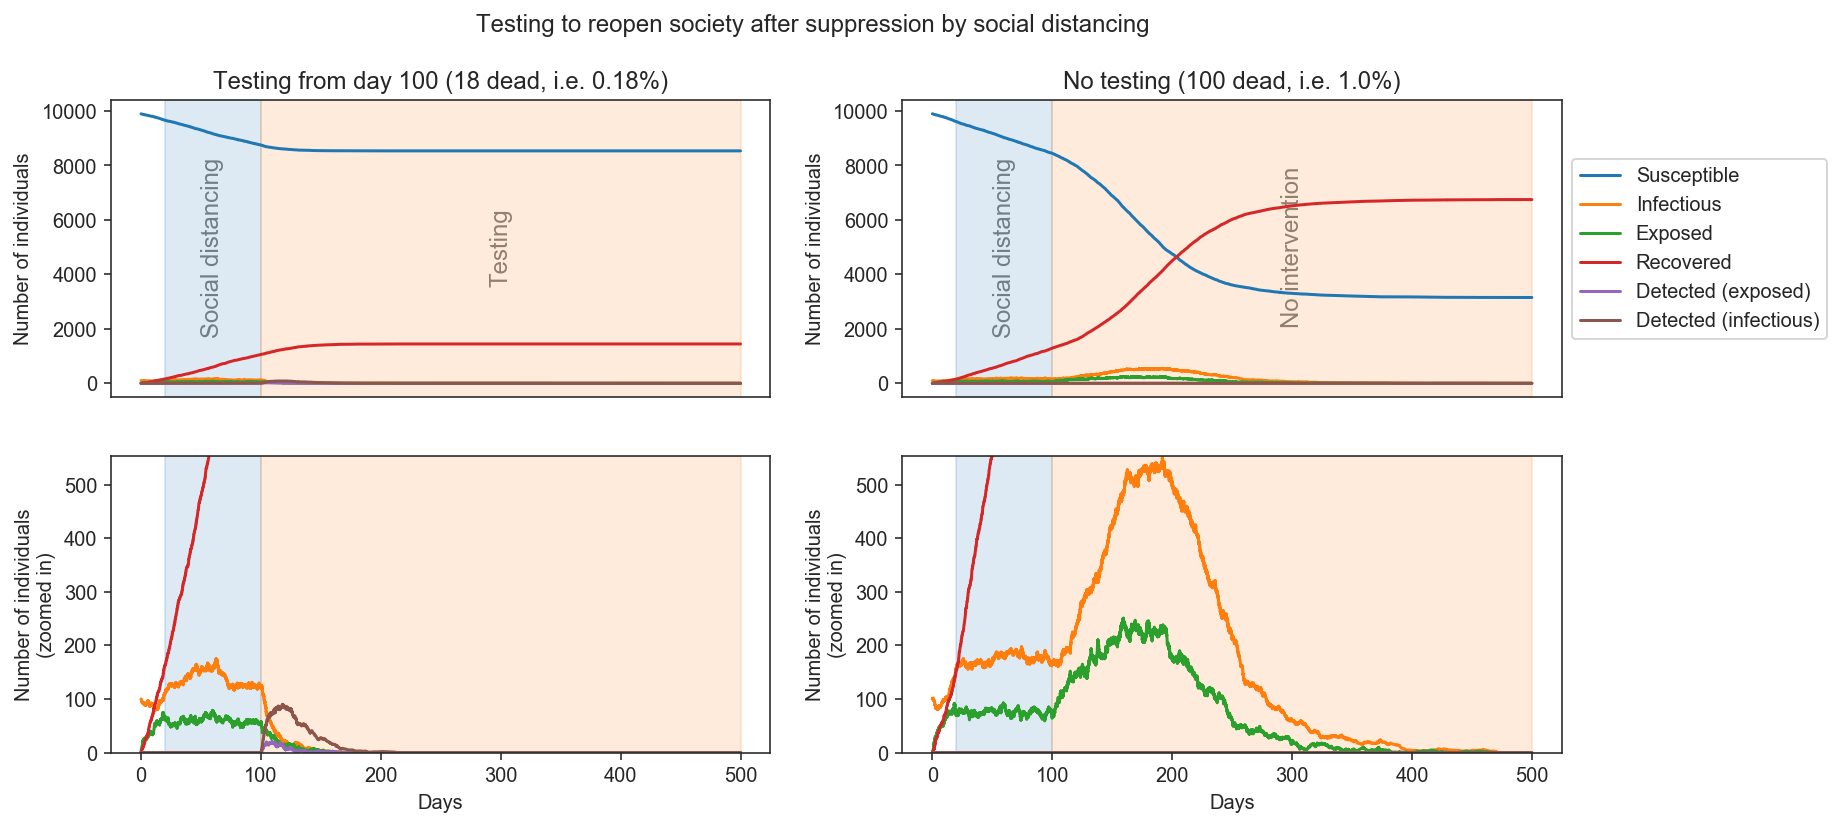

In [170]:
numNodes = 10000
n_days = 500
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_distancing = custom_exponential_graph(baseGraph, scale=10)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)

model_params = dict(
    G=G_normal,             # Social graph under normal conditions
    beta=0.155,             # Rate of transmission (transmissions per S-I contact per day)
    sigma=1/5.2,            # Rate of progression (inverse of incubation period)
    gamma=1/12.39,          # Rate of recovery (inverse of infectiopus period)
    mu_I=0.001,             # Death rate of infected individuals
    p=0.5,                  # Locality of contacts (p=0, only local; p=1, only global)
    Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
    beta_D=0.155,           # Rate of transmission for detected cases
    sigma_D=1/5.2,          # Rate of progression for detected cases
    gamma_D=1/12.39,        # Rate of recovery for detected cases
    mu_D=0.001,             # Death rate of detected individuals 
    theta_E=0,              # Rate of testing for exposed individuals
    theta_I=0,              # Rate of testing for infectious individuals
    phi_E=0,                # Rate of contact tracing testing for exposed individuals
    phi_I=0,                # Rate of contact tracing testing for infectious individuals
    psi_E=0.8,              # probability that an exposed individual is correctly identified when tested
    psi_I=0.8,              # probability that an infected individual is correctly identified when tested
    q=0.02,                 # Probability of global interactions for quarantined individuals
    initI=100               # Initial number of infected individuals
)


dist_start = 20 # On what day do we start social distancing?
test_start = 100 # On what day do we start testing?
test_fraction = 1/7 # probability that a person is tested any given day

model = SEIRSNetworkModel(**model_params)
checkpoints = {'t': [dist_start, test_start], 'G': [G_distancing, G_normal], 'p': [0.02, 0.5], 'theta_E': [0, test_fraction], 'theta_I': [0, test_fraction]}
model.run(T=n_days, checkpoints=checkpoints, verbose=False)

# Control model, identical to the above, except we don't start testing at the testing checkpoint
cmodel = SEIRSNetworkModel(**model_params)
checkpoints = {'t': [dist_start, test_start], 'G': [G_distancing, G_normal], 'p': [0.02, 0.5], 'theta_E': [0, 0], 'theta_I': [0, 0]}
cmodel.run(T=n_days, checkpoints=checkpoints, verbose=False)
plot_models(model, cmodel, [(dist_start, "Social distancing"), (test_start, "Testing")], [(dist_start, "Social distancing"), (test_start, "No intervention")], "Testing to reopen society after suppression by social distancing")

In [152]:
def plot_degree_distn(graph, max_degree=None, show=True, use_seaborn=True):
    import matplotlib.pyplot as pyplot
    if(use_seaborn):
        import seaborn
        seaborn.set_style('ticks')
        seaborn.despine()
    # Get a list of the node degrees:
    if type(graph)==numpy.ndarray:
        nodeDegrees = graph.sum(axis=0).reshape((graph.shape[0],1))   # sums of adj matrix cols
    elif type(graph)==networkx.classes.graph.Graph:
        nodeDegrees = [d[1] for d in graph.degree()]
    else:
        raise BaseException("Input an adjacency matrix or networkx object only.")
    # Calculate the mean degree:
    meanDegree = numpy.mean(nodeDegrees)
    # Generate a histogram of the node degrees:
    pyplot.hist(nodeDegrees, bins=range(max(nodeDegrees)), alpha=0.5, color='tab:blue', label=('mean degree = %.1f' % meanDegree))
    pyplot.xlim(0, max(nodeDegrees) if not max_degree else max_degree)
    pyplot.xlabel('degree')
    pyplot.ylabel('num nodes')
    pyplot.legend(loc='upper right')
    if(show):
        pyplot.show()

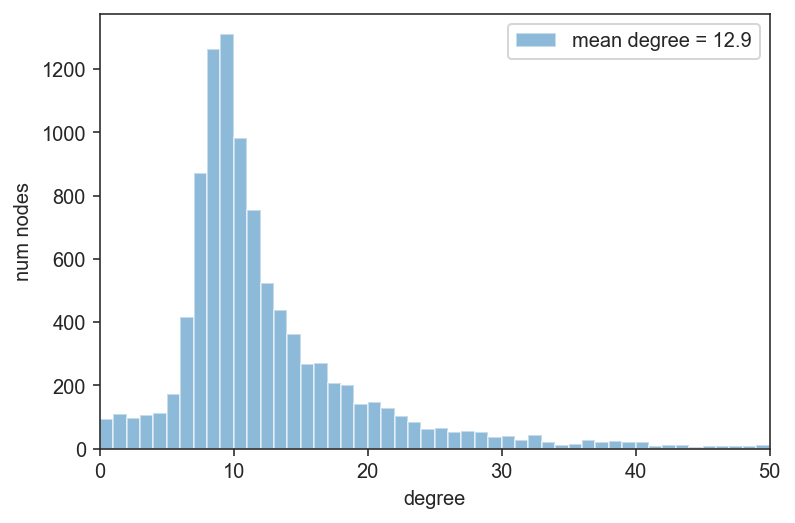

In [169]:
plot_degree_distn(G_normal, max_degree=50)
